# Построение рекомендательной системы  
Для начала подключим необходимые бибилиотеки

In [1]:
import pandas as pd
import numpy as np
import os

from time import time
import gensim
from gensim.models import doc2vec
from collections import namedtuple

%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

import random

C:\Users\evaqw\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Чтения и чистка данных
Теперь прочитаем наши файлы и переведем их в необходимый формат, а именно:
* все буквы в нижнем регистре  
* избавляемся от знаков препинания, цифр, скобок, переносов строки, дублированных пробелов и предлогов

In [2]:
# Чтение
files = os.listdir("/Users\Admin\Pictures\HSE\Курсовая\data")

descriptions = []
punctuation = """.,?!:+;(){}[]-_0123456789"""
prepositions = [' и ',' а ', ' со ',' на ',' с ',' в ',' из ',' за ','<br />','\\n','\\t','   ','  ','/','/t', '\t','\n']
for file_name in files[1:-2]:
#     print(file_name)
    s = open(file_name).read()[1:-1].lower()
    # Очистка
    for p in punctuation:
        s = s.replace(p, ' ')
    s = s.replace('<br />', '').replace('\\n','').replace('\\t','').replace('/', '')
    s = " ".join(s.split())
    if ' '.join(s.split()) != '':
        descriptions.append(s)
    
f = pd.read_csv('locations.csv')
files = list(f.description)
for file_name in files:
    s = file_name.lower()    
    for p in punctuation:
        s = s.replace(p, ' ')
    for p in prepositions:
        s = s.replace(p, ' ')
    if ' '.join(s.split()) != '':
        descriptions.append(s)
    
doc1 = descriptions
print('Количество строк:', len(doc1))
print('Количество уникальных', len(np.unique(doc1)))

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(doc1):
    docs.append(analyzedDocument(text.split(), [i]))


Количество строк: 758
Количество уникальных 477


### Обучение Doc2Vec  
Теперь обучим нашу модель Doc2Vec. Количество эпох подбиралось опытным путем.

In [3]:
max_epochs = 30
vec_size = 100
alpha = 0.025

model = doc2vec.Doc2Vec(docs,size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)

# model.build_vocab(docs)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(docs,
                total_examples=model.corpus_count,
                epochs=model.iter)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

# model.save("d2v.model")
# model = doc2vec.Doc2Vec.load("d2v.model")

C:\Users\evaqw\anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
C:\Users\evaqw\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:322: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


iteration 0


<ipython-input-3-d37aca60f380>:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  epochs=model.iter)


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29


Взглянем, какие предложения расположены наиболее близко друг к другу по мнению Doc2Vec.

In [4]:
i = 149
print(f'Предложение:\n{doc1[i]}\nНаиболее близкие к нему:\n{doc1[model.docvecs.most_similar(i)[0][0]]}\n{doc1[model.docvecs.most_similar(i)[2][0]]}')
print()
i = 500
print(f'Предложение:\n{doc1[i]}\nНаиболее близкие к нему:\n{doc1[model.docvecs.most_similar(i)[0][0]]}\n{doc1[model.docvecs.most_similar(i)[2][0]]}')

Предложение:
ангар с гримерной комнатой
Наиболее близкие к нему:
ангар гримерной комнатой москва
одноэтажный автосервис с синими стенами

Предложение:
завод довоенной постройки необычные конструктивистские корпуса цеха заброшеном состоянии атмосфера довоенной промзоны железнодорожные пути платформы атмосфера места котором ведутся боевые действия москва         ювао
Наиболее близкие к нему:
музей фарфора здании оранжереи xviii века стеклянные витрины антикварными изделиями фарфора москва         ювао
подъезд доходного дома начала xx века широкие лестничные пролеты оригинальные деревянные двери медальоны античными сюжетами стенах москва         цао


### Уменьшение размерности  
Далее будем уменьшать размерность данных, чтобы визуализировать и кластеризовать наши описания площадок. Попробуем четыре метода: PCA, TSNE, TSNE на PCA и UMAP. Визуализируем и выберем наиболее подходящий

In [5]:
b1, b2 = [], []
for i in range(len(model.docvecs)):
    b1 = np.append(b1, doc1[i])    
    b2.append(model.docvecs[i])
vectors = pd.DataFrame(b2)

In [6]:
time_start = time()
pca = PCA(n_components=2)
pca_res = pca.fit_transform(vectors)
print('PCA done! Time elapsed: {} seconds'.format(time()-time_start))
print('Cumulative explained variation for PCA_2: {}'.format(np.sum(pca.explained_variance_ratio_)))

time_start = time()
tsne = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=300)
tsne_res = tsne.fit_transform(vectors)
print('TSNE done! Time elapsed: {} seconds'.format(time()-time_start))

time_start = time()
umap_ = umap.UMAP(n_components=2)
umap_res = umap_.fit_transform(vectors)
print('UMAP done! Time elapsed: {} seconds'.format(time()-time_start))

time_start = time()
pca40 = PCA(n_components=40)
pca40_tsne = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=300)
pca40_tsne_res = pca40_tsne.fit_transform(pca40.fit_transform(vectors))
print('TSNE on PCA_40 done! Time elapsed: {} seconds'.format(time()-time_start))
print('Cumulative explained variation for PCA_40: {}'.format(np.sum(pca40.explained_variance_ratio_)))

PCA done! Time elapsed: 0.010372638702392578 seconds
Cumulative explained variation for PCA_2: 0.2753987026949585
TSNE done! Time elapsed: 1.047940731048584 seconds
UMAP done! Time elapsed: 14.76286792755127 seconds
TSNE on PCA_40 done! Time elapsed: 1.424947738647461 seconds
Cumulative explained variation for PCA_40: 0.9903541998561252


<AxesSubplot:xlabel='umap_x', ylabel='umap_y'>

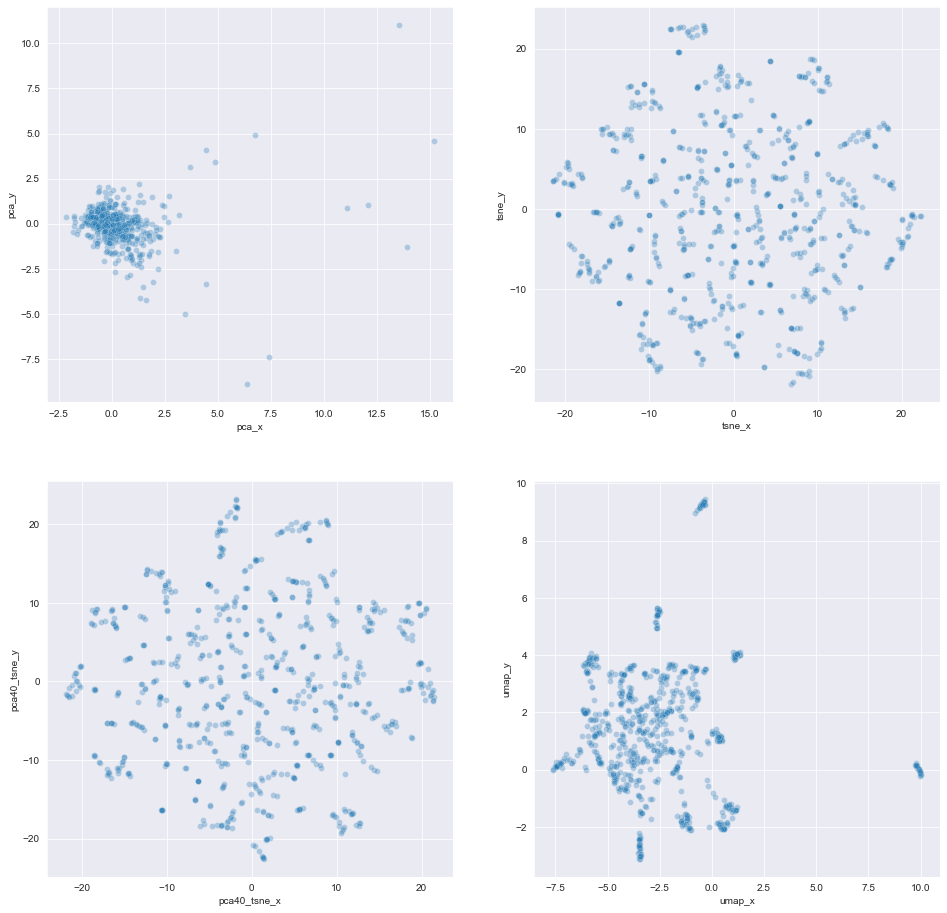

In [7]:
df_picture = pd.DataFrame()
df_picture['sentence'] = b1
df_picture['pca_x'] = pca_res[:,0]
df_picture['pca_y'] = pca_res[:,1]
df_picture['tsne_x'] = tsne_res[:,0]
df_picture['tsne_y'] = tsne_res[:,1]
df_picture['pca40_tsne_x'] = pca40_tsne_res[:,0]
df_picture['pca40_tsne_y'] = pca40_tsne_res[:,1]
df_picture['umap_x'] = umap_res[:,0]
df_picture['umap_y'] = umap_res[:,1]


plt.figure(figsize=(16,16))
ax1 = plt.subplot(2, 2, 1)
sns.scatterplot(x="pca_x", y="pca_y",data=df_picture,alpha=0.3,ax=ax1
)
ax2 = plt.subplot(2, 2, 2)
sns.scatterplot(x="tsne_x", y="tsne_y",data=df_picture,alpha=0.3,ax=ax2
)
ax3 = plt.subplot(2, 2, 3)
sns.scatterplot(x="pca40_tsne_x", y="pca40_tsne_y",data=df_picture,alpha=0.3,ax=ax3
)
ax4 = plt.subplot(2, 2, 4)
sns.scatterplot(x="umap_x", y="umap_y",data=df_picture,alpha=0.3,ax=ax4
)

Видно, что PCA совсем плох по кол-ву сохраняемой дисперсии и на графике. TSNE и PCAonTSNE показывают примерно равные результаты, поэтому оставим PCAonTSNE и UMAP, далее посмотрим, что даст кластеризация.  
### Кластеризация  
Если запустить закомментированный код, то можно убедиться, что DBSCAN сработал хуже всего. Он оставил один огромный кластер и добавил парочку маленьких. Результаты SpectralClustering не сильно отличаются от K-Means, поэтому выберем K-Means

In [8]:
n_clusters = 25
# ind = df_picture.sentence.drop_duplicates().index
# df_picture = df_picture.loc[ind, :]

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_res_pca40tsne = kmeans.fit(df_picture.loc[:, ['pca40_tsne_x','pca40_tsne_y']])
kmeans_res_umap = kmeans.fit(df_picture.loc[:, ['umap_x','umap_y']])
df_picture['labels_pca40tsne_kmeans'] = kmeans_res_pca40tsne.labels_
df_picture['labels_umap_kmeans'] = kmeans_res_umap.labels_

# dbscan = DBSCAN(eps=3, min_samples=5)
# dbscan_res_tsne = dbscan.fit(df_picture.loc[:, ['tsne_x','tsne_y']])
# dbscan_res_umap = dbscan.fit(df_picture.loc[:, ['umap_x','umap_y']])
# df_picture['labels_tsne_dbscan'] = dbscan_res_tsne.labels_
# df_picture['labels_umap_dbscan'] = dbscan_res_umap.labels_

# sc = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=42)
# sc_res_tsne = sc.fit(df_picture.loc[:, ['tsne_x','tsne_y']])
# sc_res_umap = sc.fit(df_picture.loc[:, ['umap_x','umap_y']])
# df_picture['labels_tsne_sc'] = sc_res_tsne.labels_
# df_picture['labels_umap_sc'] = sc_res_umap.labels_

Text(0.5, 1.0, 'K-means on UMAP')

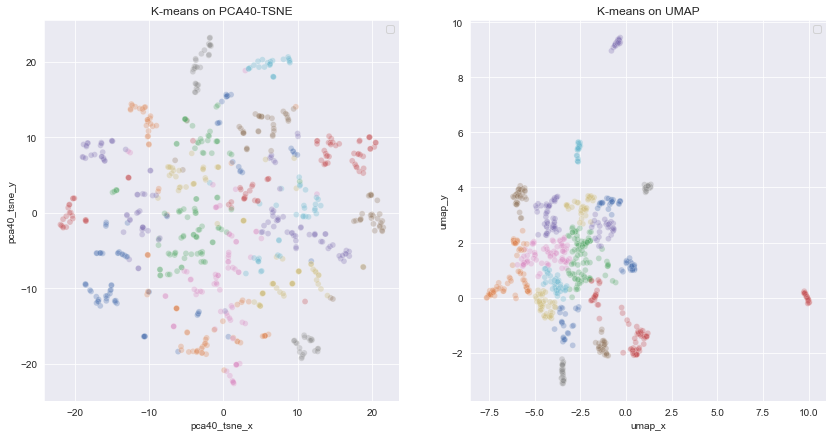

In [9]:
plt.figure(figsize=(14, 7))
m, n = 1,2

ax1 = plt.subplot(m,n,1)
buf = sns.scatterplot(x="pca40_tsne_x", 
                y="pca40_tsne_y",
                data=df_picture,
                hue='labels_pca40tsne_kmeans',
                alpha=0.3,ax=ax1,palette="deep").legend([],[])
ax1.set_title('K-means on PCA40-TSNE')
ax2 = plt.subplot(m,n,2)
sns.scatterplot(x="umap_x", 
                y="umap_y",
                data=df_picture,
                hue='labels_umap_kmeans',
                alpha=0.3,ax=ax2,palette="deep").legend([],[])
ax2.set_title('K-means on UMAP')

# ax3 = plt.subplot(m,n,3)
# buf = sns.scatterplot(x="tsne_x", 
#                 y="tsne_y",
#                 data=df_picture,
#                 hue='labels_tsne_dbscan',
#                 alpha=0.3,ax=ax3,palette="deep").legend([],[])
# ax3.set_title('DBSCAN on TSNE')
# ax4 = plt.subplot(m,n,4)
# sns.scatterplot(x="umap_x", 
#                 y="umap_y",
#                 data=df_picture,
#                 hue='labels_umap_dbscan',
#                 alpha=0.3,ax=ax4,palette="deep").legend([],[])
# ax4.set_title('DBSCAN on UMAP')

# ax5 = plt.subplot(m,n,1)
# buf = sns.scatterplot(x="tsne_x", 
#                 y="tsne_y",
#                 data=df_picture,
#                 hue='labels_tsne_sc',
#                 alpha=0.3,ax=ax5,palette="deep").legend([],[])
# ax5.set_title('SpectralClustering on TSNE')
# ax6 = plt.subplot(m,n,2)
# sns.scatterplot(x="umap_x", 
#                 y="umap_y",
#                 data=df_picture,
#                 hue='labels_umap_sc',
#                 alpha=0.3,ax=ax6,palette="deep").legend([],[])
# ax6.set_title('SpectralClustering on UMAP')



In [10]:
a = df_picture[df_picture['labels_pca40tsne_kmeans'] != df_picture['labels_umap_kmeans']].shape[0]
print(f'Кол-во различий между PCA-40: {a}')


Кол-во различий между PCA-40: 0


На обеих моделях снижения размерности кластеризация сработала одинаково, поэтому можно оставлять любой. Возьмем UMAP, так как на графике для него кластеры лучше видны и сгруппированы.  
Посмотрим на кластеры

In [11]:
df_picture = df_picture.drop(columns='labels_pca40tsne_kmeans')
df_picture = df_picture.rename(columns = {'labels_umap_kmeans': 'labels'})

clusters = df_picture.labels.unique()
for i in clusters:
    buf = df_picture[df_picture['labels'] == i].sentence
    print(f'РАЗМЕР КЛАСТЕРА: {buf.shape[0]}')
    buf = buf.drop_duplicates()
    print(f'УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: {buf.shape[0]}')
    for j in buf:
        print(j)
    print()

РАЗМЕР КЛАСТЕРА: 22
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 21
школа бортпроводников общий вид площадок объектов самолетов зеленые насаждения
салон cамолета кабина
школа бортпроводников общий вид площадок объектов самолетов зеленые насаждения test
переговорная современным интерьером светлых тонах большими окнами винтовой лестницей   посадочных мест москва         свао
открытая стоянка городской среде современная архитектура 
автотехцентр купольным залом вращающимся кругом москва         свао
двор стиле ранней советской архитектуры трехэтажные здания атмосферное пространство вид останкинскую телебашню 
современный культурный цент большими окнами актовым залом просторными коридорами   мо
павильон музея космоса стеклянным куполом москва         свао
помпезный театр двухуровневым зрительским залом
стандартная больница кабинетами длинными коридорами 
современная стоматологическая клиника москва         свао
стоматология премиум класса самом центре москвы 
двухуровневая библиотека читальным залом 
школа тре

### Построение рекомендательной системы  
Наша рекомендательная система смотрит на очередной запрос пользователя и запоминает индекс соответствующей площадки. Далее она находит по индексу она находит площадку в базе данных и смотрит на кластер, к которому эта площадка относится. Рекомендует соответственно рандомную площадку из этого же кластера.

In [12]:
def RecomedationSistem(ind_query):
    users_query = doc1[ind_query]
    label = df_picture[df_picture['sentence'] == users_query].labels.unique()[0]
    most_similar_d2v = model.docvecs.most_similar(ind_query)[0][0]
    recomendation = random.choice(df_picture[(df_picture.index != ind_query) & (df_picture['labels'] == label)].index)

    print(f'Пользователь ранее кликал на предложение:\n\t{users_query}')
    print(f'Рекомендательная система предложила:\n\t{doc1[recomendation]}')
    print(f'Модель Doc2Vec считает, что наиболее близкие запрос:\n\t{doc1[most_similar_d2v]}')

In [13]:
for i in range(5):
    print(f'TEST {i}')
    RecomedationSistem(random.choice(range(len((doc1)))))
    print()

TEST 0
Пользователь ранее кликал на предложение:
	большой заброшенный завод котором ещё сохранились старые станки 
Рекомендательная система предложила:
	пляж песчаным заходом 
Модель Doc2Vec считает, что наиболее близкие запрос:
	большой хвойный лес центре которого располагается зеленая поляна 

TEST 1
Пользователь ранее кликал на предложение:
	ангар для стоянки бизнес джетов москва
Рекомендательная система предложила:
	ангар для стоянки бизнес джетов москва
Модель Doc2Vec считает, что наиболее близкие запрос:
	ангар для стоянки бизнес джетов москва

TEST 2
Пользователь ранее кликал на предложение:
	современный просторный концертный зал 
Рекомендательная система предложила:
	застройка классическом стиле использование элементов декора фасадах лепнина балкон над входной группой пилястры зеленые насаждения придомовой территории 
Модель Doc2Vec считает, что наиболее близкие запрос:
	современный просторный офис лофт ослепительно белыми стенами москва         вао

TEST 3
Пользователь ранее к

Есть минус в данных в том, что описания на реальном сайте вряд ли будут повторяться в таком количестве.  
Можно ли избавиться от кластеризации и просто выдавать ближайший запрос? Наверное нет, так как нам всегда нужно выдавать новое, рандомное предложение. Хотя, минуя визуализацию и снижение размерности, можно основываться на ближайших соседях по мнению Doc2Vec. Однако, совершенная рекомендательная система будет основываться не только на тексте описания.  
Есть минус в модели, так как не обрабатывает русский текст. В процессе...  
Предложение: рекомендовать так же по местонахождению